In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
ROOT_PATH = "/content/drive/MyDrive/WOA7105_assignment"
PROCEED_PATH = "/content/drive/MyDrive/WOA7105_assignment/baseline_vqa_results_output/"

🚀 STARTING COMPLETE MED-VQA BASELINE PIPELINE
🚀 Using device: cuda
🔢 PyTorch version: 2.9.0+cu126
🔧 1. Processing VQA-RAD dataset...
--------------------------------------------------
📂 Loading data from: /content/drive/MyDrive/WOA7105_assignment/VQA_RAD Dataset Public.json
📊 Dataset statistics:
   - Initial samples: 2248
   - After cleaning: 2248
   - Removed: 0 samples

📈 Data Split Summary:
   - Training set: 1,574 samples (70.0%)
   - Validation set: 337 samples (15.0%)
   - Test set: 337 samples (15.0%)

❓ Question Type Distribution:
   Train: CLOSED: 920 (58.4%) | OPEN: 654 (41.6%) | 
   Val: CLOSED: 195 (57.9%) | OPEN: 142 (42.1%) | 
   Test: CLOSED: 184 (54.6%) | OPEN: 153 (45.4%) | 

2. Building Language Resources
📚 Building vocabulary from: /content/drive/MyDrive/WOA7105_assignment/baseline_vqa_results_output/train_split.csv
📊 Vocabulary Statistics:
   - Total words: 1360
   - Vocabulary size: 692
   - Coverage: 50.9% of unique words

🏆 Top 10 most frequent words:
   - 'the':

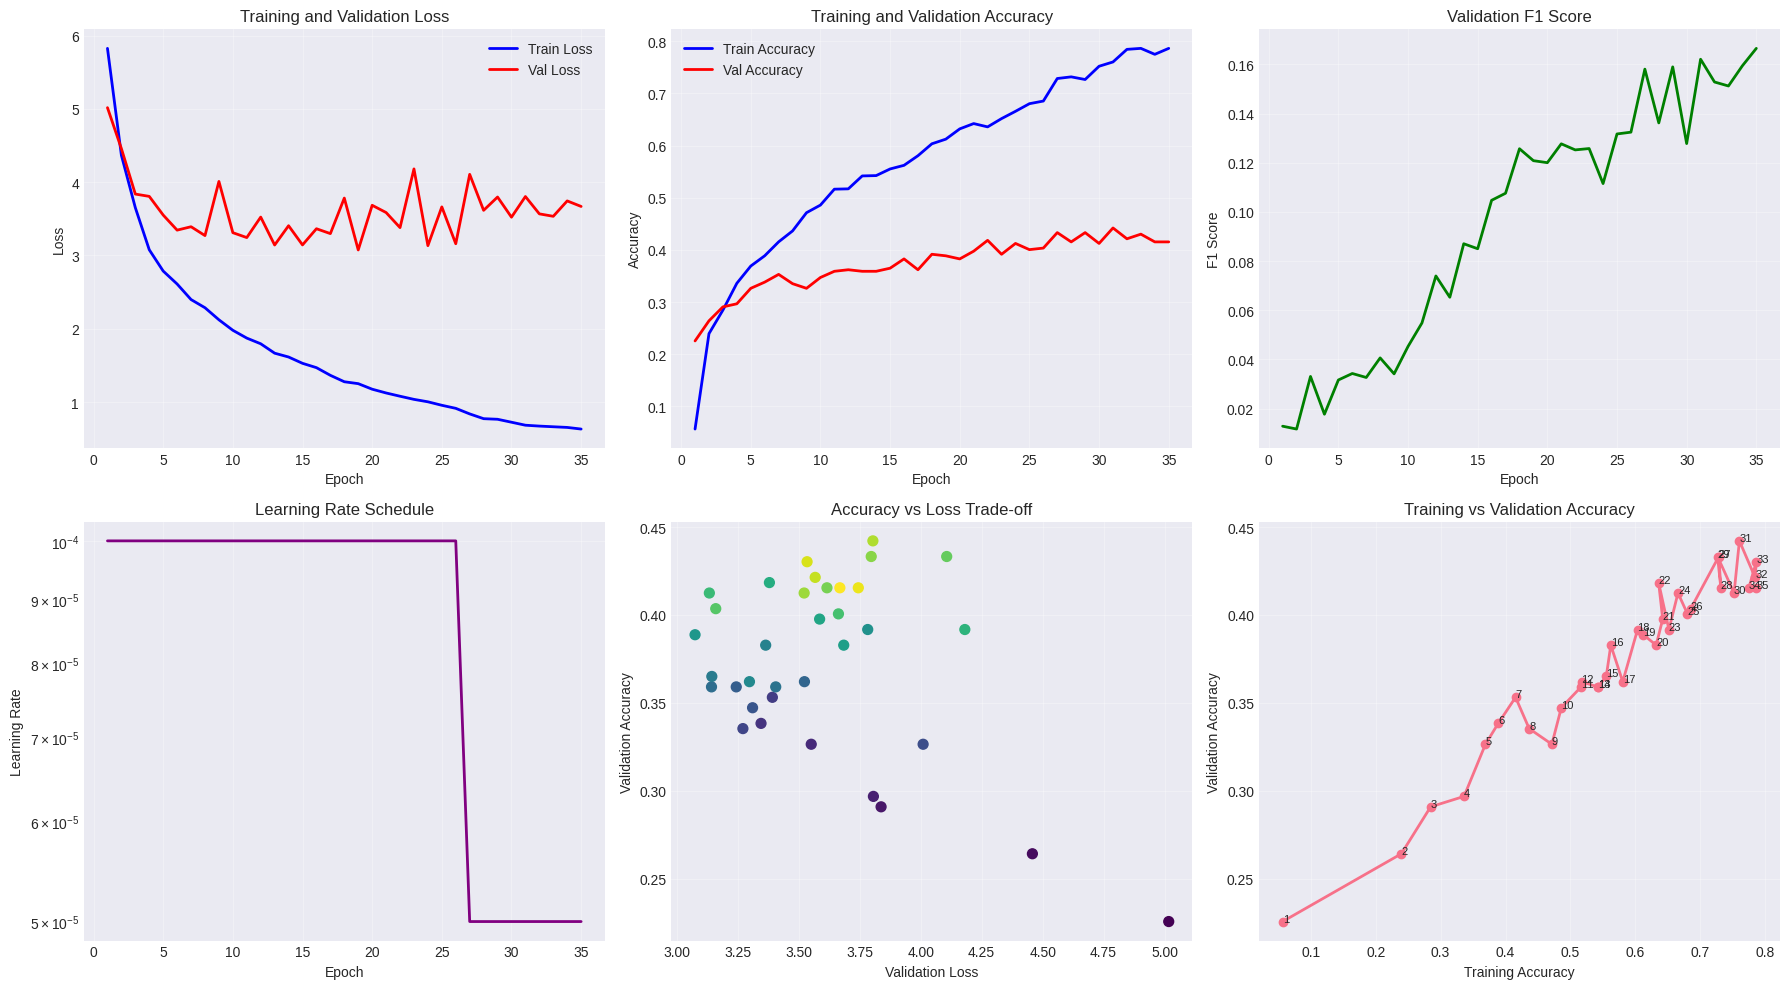

📈 Training plots saved to: /content/drive/MyDrive/WOA7105_assignment/baseline_vqa_results_output/training_history.png

8. TEST SET EVALUATION

🧪 Evaluating on Test Set
----------------------------------------

📊 Test Set Performance:
   - Loss: 4.6315
   - Accuracy: 0.3383
   - F1 Score: 0.1364
   - Precision: 0.1454
   - Recall: 0.1327

❓ Performance by Question Type:
   - CLOSED: 0.4946 (91/184)
   - OPEN: 0.1503 (23/153)

💾 Results saved to: /content/drive/MyDrive/WOA7105_assignment/baseline_vqa_results_output/test_results.json
💾 Model saved to: /content/drive/MyDrive/WOA7105_assignment/baseline_vqa_results_output/final_model.pth

9. ERROR ANALYSIS

🔍 Error Analysis (showing 8 samples)
--------------------------------------------------

❌ Error #1:
   Question: What type of imaging is this?
   Question Type: OPEN
   True Answer: MRI Diffusion Weighted (ID: 445)
   Predicted Answer: vasculature (ID: 359)
   Confidence: True=0.000, Pred=0.985
------------------------------

❌ Error #2

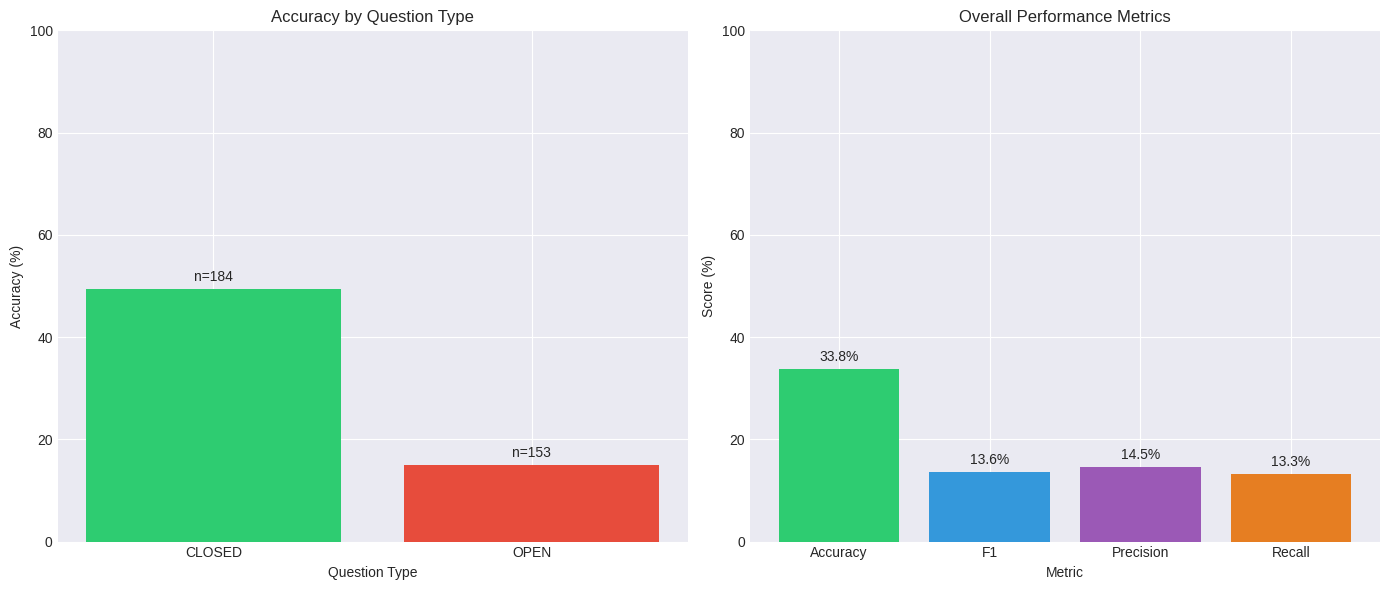


💾 Performance summary saved to: performance_summary.png

11. EXPORTING RESULTS FOR FINAL REPORT

📤 Exporting results for final report...

✅ All results exported to 'baseline_vqa_results_output' folder:
   📄 baseline_vqa_results_output/main_results.csv
   📄 baseline_vqa_results_output/question_type_results.csv
   📄 baseline_vqa_results_output/training_history.csv
   📄 baseline_vqa_results_output/model_info.csv
   📄 baseline_vqa_results_output/results_summary.txt


In [21]:
def run_complete_baseline_pipeline():
    """
    Complete pipeline for Medical VQA Baseline Model in one function
    """

    print("🚀 STARTING COMPLETE MED-VQA BASELINE PIPELINE")
    print("=" * 60)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 Using device: {device}")
    print(f"🔢 PyTorch version: {torch.__version__}")

    print("🔧 1. Processing VQA-RAD dataset...")
    print("-" * 50)

    # Adjust path if needed
    json_path = '/content/drive/MyDrive/WOA7105_assignment/VQA_RAD Dataset Public.json'
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"JSON file not found: {json_path}")

    train_df, val_df, test_df = convert_and_split_data(
        json_path=json_path,
        train_ratio=0.7,
        val_ratio=0.15,
        test_ratio=0.15
    )

    print("\n" + "=" * 50)
    print("2. Building Language Resources")
    print("=" * 50)

    vocab = build_vocab_from_train(f'{PROCEED_PATH}train_split.csv', min_freq=2)
    ans_to_id, id_to_ans = build_answer_mapping_from_train(f'{PROCEED_PATH}train_split.csv')
    unk_answer_id = ans_to_id['<UNK>']

    # Save answer mappings
    with open(f'{PROCEED_PATH}answer_mapping.json', 'w') as f:
        json.dump({'ans_to_id': ans_to_id, 'id_to_ans': id_to_ans}, f, indent=2)

    # Create datasets for all splits
    print("\n" + "=" * 50)
    print("3. Creating Dataset Objects")
    print("=" * 50)

    # Image transformations (standard for ImageNet pretrained models)
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Initialize datasets
    train_dataset = MedVQADataset(
        csv_file=f'{PROCEED_PATH}train_split.csv',
        img_dir=f'{ROOT_PATH}/VQA_RAD Image Folder/',
        vocab=vocab,
        ans_to_id=ans_to_id,
        unk_answer_id=unk_answer_id,
        transform=data_transforms,
        max_seq_len=25
    )

    val_dataset = MedVQADataset(
        csv_file=f'{PROCEED_PATH}val_split.csv',
        img_dir=f'{ROOT_PATH}/VQA_RAD Image Folder/',
        vocab=vocab,
        ans_to_id=ans_to_id,
        unk_answer_id=unk_answer_id,
        transform=data_transforms,
        max_seq_len=25
    )

    test_dataset = MedVQADataset(
        csv_file=f'{PROCEED_PATH}test_split.csv',
        img_dir=f'{ROOT_PATH}/VQA_RAD Image Folder/',
        vocab=vocab,
        ans_to_id=ans_to_id,
        unk_answer_id=unk_answer_id,
        transform=data_transforms,
        max_seq_len=25
    )

    # Analyze question types
    print("\nTraining Set:")
    train_type_counts = train_dataset.analyze_question_types()

    print("\nValidation Set:")
    val_type_counts = val_dataset.analyze_question_types()

    print("\nTest Set:")
    test_type_counts = test_dataset.analyze_question_types()

    # Initialize the model
    print("\n" + "=" * 50)
    print("4. Initializing Model")
    print("=" * 50)

    # Model parameters
    num_classes = len(ans_to_id)  # Includes UNK class
    vocab_size = len(vocab)

    # Create model instance
    model = MedVQA_ResNet_LSTM(
        num_classes=num_classes,
        vocab_size=vocab_size,
        embed_dim=512,
        hidden_dim=512,
        dropout_rate=0.3,
        lstm_layers=1
    ).to(device)

    print(f"\n✅ Model initialized successfully!")
    print(f"   - Device: {device}")
    print(f"   - Number of classes: {num_classes}")
    print(f"   - Vocabulary size: {vocab_size}")

    # Create data loaders
    print("\n" + "=" * 50)
    print("5. Creating Data Loaders")
    print("=" * 50)

    BATCH_SIZE = 16  # Reduced for memory efficiency
    NUM_WORKERS = 2 if torch.cuda.is_available() else 0

    train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset,
                                                                batch_size=BATCH_SIZE,
                                                                num_workers=NUM_WORKERS
                                                                )

    # Display sample batch
    print("\n🔍 Sample batch inspection:")
    sample_batch = next(iter(train_loader))
    print(f"   - Image shape: {sample_batch['image'].shape}")  # [B, 3, 224, 224]
    print(f"   - Question shape: {sample_batch['question_seq'].shape}")  # [B, seq_len]
    print(f"   - Label shape: {sample_batch['answer_label'].shape}")  # [B]
    print(f"   - Question types: {sample_batch['question_type'][:3]}")

    # %%
    # Start training
    print("\n" + "=" * 60)
    print("6. TRAINING PHASE")
    print("=" * 60)

    # Training parameters
    EPOCHS = 35  # Reduced for faster training
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-4
    PATIENCE = 10

    # EPOCHS = 60  # Reduced for faster training
    # LEARNING_RATE =  5e-4
    # WEIGHT_DECAY = 0.005
    # PATIENCE = 12

    # Train the model
    history, best_val_acc = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        num_epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        patience=PATIENCE,
    )

    print(f"\n🎉 Training completed!")
    print(f"   Best validation accuracy: {best_val_acc:.4f}")

    print("\n" + "=" * 50)
    print("7. Visualizing Training Results")
    print("=" * 50)

    plot_training_history(history, f'{PROCEED_PATH}training_history.png')

    # Evaluate on test set
    print("\n" + "=" * 60)
    print("8. TEST SET EVALUATION")
    print("=" * 60)

    test_metrics, detailed_results = evaluate_test_set(
        model=model,
        test_loader=test_loader,
        device=device,
        num_classes=num_classes,
        vocab_size=vocab_size,
        vocab=vocab,
        ans_to_id=ans_to_id,
        id_to_ans=id_to_ans,
        save_results=True
    )

    # Perform error analysis
    print("\n" + "=" * 50)
    print("9. ERROR ANALYSIS")
    print("=" * 50)

    analyze_errors(model, test_loader, device, id_to_ans, num_samples=8)
    show_sample_predictions(model, test_loader, device, id_to_ans, num_samples=5)

    # Generate performance summary
    print("\n" + "=" * 50)
    print("10. GENERATING PERFORMANCE SUMMARY")
    print("=" * 50)

    create_performance_summary(test_metrics, detailed_results['type_stats'], history)

    # Export results
    print("\n" + "=" * 60)
    print("11. EXPORTING RESULTS FOR FINAL REPORT")
    print("=" * 60)

    export_results_for_report(
        test_metrics=test_metrics,
        type_stats=detailed_results['type_stats'],
        history=history,
        model_info=detailed_results['model_info']
    )

run_complete_baseline_pipeline()

In [19]:
# %%
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
import json
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import warnings

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")




## 2. Data Preparation and Preprocessing


# %%
def convert_and_split_data(json_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Convert VQA-RAD JSON data to CSV and split into train/val/test sets

    Parameters:
    -----------
    json_path : str
        Path to the VQA-RAD JSON file
    train_ratio : float
        Proportion of data for training (default: 0.7)
    val_ratio : float
        Proportion of data for validation (default: 0.15)
    test_ratio : float
        Proportion of data for testing (default: 0.15)
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    train_df, val_df, test_df : pandas.DataFrame
        DataFrames for train, validation, and test sets
    """
    # Validate ratio sum
    total_ratio = train_ratio + val_ratio + test_ratio
    if abs(total_ratio - 1.0) > 0.001:
        raise ValueError(f"Ratios must sum to 1.0, got {total_ratio}")

    print(f"📂 Loading data from: {json_path}")

    # Load JSON data
    with open(json_path, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)

    # Parse JSON structure
    parsed_list = []
    for item in raw_data:
        parsed_list.append({
            'image_id': item.get('image_name', ''),
            'question': item.get('question', ''),
            'answer': str(item.get('answer', '')),
            'answer_type': item.get('answer_type', '')
        })

    # Create DataFrame and remove missing values
    df = pd.DataFrame(parsed_list)
    initial_count = len(df)
    df = df.dropna(subset=['image_id', 'question', 'answer'])
    cleaned_count = len(df)

    print(f"📊 Dataset statistics:")
    print(f"   - Initial samples: {initial_count}")
    print(f"   - After cleaning: {cleaned_count}")
    print(f"   - Removed: {initial_count - cleaned_count} samples")

    # strip the list(essensial)
    df['answer_type'] = df['answer_type'].str.strip()

    # Dataset split
    train_df = df.sample(frac=train_ratio, random_state=random_state)
    remaining_df = df.drop(train_df.index)

    # Calculate validation set size from remaining data
    val_size = val_ratio / (val_ratio + test_ratio)
    val_df = remaining_df.sample(frac=val_size, random_state=random_state)
    test_df = remaining_df.drop(val_df.index)


    # Save splits to CSV files
    train_df.to_csv(f'{PROCEED_PATH}train_split.csv', index=False)
    val_df.to_csv(f'{PROCEED_PATH}val_split.csv', index=False)
    test_df.to_csv(f'{PROCEED_PATH}test_split.csv', index=False)

    # Print split statistics
    print("\n📈 Data Split Summary:")
    print(f"   - Training set: {len(train_df):,} samples ({train_ratio * 100:.1f}%)")
    print(f"   - Validation set: {len(val_df):,} samples ({val_ratio * 100:.1f}%)")
    print(f"   - Test set: {len(test_df):,} samples ({test_ratio * 100:.1f}%)")

    # Question type distribution
    print("\n❓ Question Type Distribution:")
    for split_name, split_df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
        type_counts = split_df['answer_type'].value_counts()
        print(f"   {split_name}: ", end="")
        for qtype, count in type_counts.items():
            print(f"{qtype}: {count} ({count / len(split_df) * 100:.1f}%)", end=" | ")
        print()

    return train_df, val_df, test_df


## 3. Vocabulary and Answer Mapping Construction

# %%
def build_vocab_from_train(train_csv_path, min_freq=1, save_path=f'{PROCEED_PATH}vocab.json'):
    """
    Build vocabulary dictionary from training set questions

    Parameters:
    -----------
    train_csv_path : str
        Path to training CSV file
    min_freq : int
        Minimum word frequency to include in vocabulary
    save_path : str
        Path to save vocabulary JSON file

    Returns:
    --------
    vocab : dict
        Word to index mapping dictionary
    """
    print(f"📚 Building vocabulary from: {train_csv_path}")

    # Load training data
    train_df = pd.read_csv(train_csv_path)

    # Count word frequencies
    word_counter = collections.Counter()
    for question in train_df['question']:
        # Tokenize: lowercase and split
        words = str(question).lower().split()
        word_counter.update(words)

    # Build vocabulary with special tokens
    vocab = {
        "<PAD>": 0,  # Padding token
        "<UNK>": 1,  # Unknown word token
        "<SOS>": 2,  # Start of sentence (optional)
        "<EOS>": 3  # End of sentence (optional)
    }

    # Add frequent words
    for word, freq in word_counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)

    # Save vocabulary
    with open(save_path, 'w') as f:
        json.dump(vocab, f, indent=2)

    # Vocabulary statistics
    print(f"📊 Vocabulary Statistics:")
    print(f"   - Total words: {len(word_counter)}")
    print(f"   - Vocabulary size: {len(vocab)}")
    print(f"   - Coverage: {len(vocab) / len(word_counter) * 100:.1f}% of unique words")

    # Show most common words
    print(f"\n🏆 Top 10 most frequent words:")
    for word, freq in word_counter.most_common(10):
        print(f"   - '{word}': {freq} occurrences")

    return vocab


def build_answer_mapping_from_train(train_csv_path):
    """
    Build answer to ID mapping from training set only (prevents data leakage)

    Parameters:
    -----------
    train_csv_path : str
        Path to training CSV file

    Returns:
    --------
    ans_to_id : dict
        Answer text to ID mapping
    id_to_ans : dict
        ID to answer text mapping
    """
    print(f"🔤 Building answer mapping from: {train_csv_path}")

    # Load training data
    train_df = pd.read_csv(train_csv_path)

    # Get unique answers from training set only
    unique_answers = train_df['answer'].unique()

    # Create mappings
    ans_to_id = {ans: idx for idx, ans in enumerate(unique_answers)}
    id_to_ans = {idx: ans for ans, idx in ans_to_id.items()}

    # Add UNK token for unseen answers in val/test sets
    unk_id = len(ans_to_id)
    ans_to_id['<UNK>'] = unk_id
    id_to_ans[unk_id] = '<UNK>'

    # Answer statistics
    print(f"📊 Answer Statistics:")
    print(f"   - Unique answers in training set: {len(unique_answers)}")
    print(f"   - Total classes (with UNK): {len(ans_to_id)}")

    # Show most common answers
    answer_counts = train_df['answer'].value_counts()
    print(f"\n🏆 Top 10 most frequent answers:")
    for answer, count in answer_counts.head(10).items():
        print(f"   - '{answer}': {count} occurrences ({count / len(train_df) * 100:.1f}%)")

    return ans_to_id, id_to_ans


## 4. Custom Dataset Class

# %%
class MedVQADataset(Dataset):
    """
    PyTorch Dataset class for Medical Visual Question Answering

    Handles:
    - Image loading and preprocessing
    - Question tokenization
    - Answer label encoding
    - Question type tracking
    """

    def __init__(self, csv_file, img_dir, vocab, ans_to_id, unk_answer_id, transform=None,
                 max_seq_len=25, img_size=(224, 224)):
        """
        Initialize the dataset

        Parameters:
        -----------
        csv_file : str
            Path to CSV file containing questions and answers
        img_dir : str
            Directory containing medical images
        vocab : dict
            Word to index vocabulary
        ans_to_id : dict
            Answer text to ID mapping
        transform : torchvision.transforms
            Image transformation pipeline
        max_seq_len : int
            Maximum sequence length for questions
        img_size : tuple
            Target image size (height, width)
        """
        # Load data
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.vocab = vocab
        self.ans_to_id = ans_to_id
        self.unk_answer_id = unk_answer_id
        self.max_seq_len = max_seq_len
        self.img_size = img_size

        # Set up image transformations
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize(img_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

        # Validate data
        self._validate_dataset()

    def _validate_dataset(self):
        """Check dataset integrity and report issues"""
        missing_images = 0
        valid_samples = 0

        for idx in range(len(self.data)):
            img_id = self.data.iloc[idx]['image_id']
            img_path = os.path.join(self.img_dir, img_id)

            if os.path.exists(img_path):
                valid_samples += 1
            else:
                missing_images += 1

        print(f"📋 Dataset Validation:")
        print(f"   - Total samples: {len(self.data)}")
        print(f"   - Valid images: {valid_samples}")
        print(f"   - Missing images: {missing_images}")

        if missing_images > 0:
            print(f"   ⚠️ Warning: {missing_images} images not found!")

    def __len__(self):
        """Return total number of samples"""
        return len(self.data)

    def _text_to_sequence(self, text):
        """
        Convert text to sequence of token IDs

        Parameters:
        -----------
        text : str
            Input text (question)

        Returns:
        --------
        sequence : torch.Tensor
            Tensor of token IDs
        """
        # Tokenize: lowercase and split
        tokens = str(text).lower().split()

        # Convert tokens to IDs, use UNK for unknown words
        token_ids = [self.vocab.get(token, self.vocab["<UNK>"])
                     for token in tokens[:self.max_seq_len]]

        # Padding or truncation
        if len(token_ids) < self.max_seq_len:
            # Pad with <PAD> token
            padding = [self.vocab["<PAD>"]] * (self.max_seq_len - len(token_ids))
            token_ids = token_ids + padding
        else:
            # Truncate to max length
            token_ids = token_ids[:self.max_seq_len]

        return torch.tensor(token_ids, dtype=torch.long)

    def __getitem__(self, idx):
        """
        Get a single sample from the dataset

        Returns:
        --------
        image : torch.Tensor
            Preprocessed image tensor [3, H, W]
        question_seq : torch.Tensor
            Question token IDs [max_seq_len]
        answer_label : torch.Tensor
            Answer label (class index)
        question_type : str
            Type of question (CLOSED/OPEN/OTHER)
        original_question : str
            Original question text (for debugging)
        """
        # Get row data
        row = self.data.iloc[idx]
        img_id = row['image_id']
        question_text = row['question']
        answer_text = str(row['answer'])
        question_type = str(row['answer_type']).strip().upper()

        # Load and preprocess image
        img_path = os.path.join(self.img_dir, img_id)
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except (FileNotFoundError, OSError) as e:
            # Create blank image if file is missing
            print(f"⚠️ Could not load image {img_id}: {e}")
            image = torch.zeros(3, *self.img_size)

        # Convert question to sequence
        question_seq = self._text_to_sequence(question_text)

        # Convert answer to label (use UNK for unseen answers)
        answer_label = self.ans_to_id.get(answer_text, self.unk_answer_id)
        answer_label = torch.tensor(answer_label, dtype=torch.long)

        # Normalize question type
        if question_type not in ['CLOSED', 'OPEN']:
            question_type = 'OTHER'

        return {
            'image': image,
            'question_seq': question_seq,
            'answer_label': answer_label,
            'question_type': question_type,
            'original_question': question_text,
            'original_answer': answer_text,
            'image_id': img_id
        }

    def analyze_question_types(self):
        """Analyze distribution of question types"""
        type_counts = self.data['answer_type'].value_counts()
        print(f"\n📊 Question Type Analysis:")
        for qtype, count in type_counts.items():
            percentage = count / len(self.data) * 100
            print(f"   - {qtype}: {count} samples ({percentage:.1f}%)")

        return type_counts


# 5. Model Architecture


# %%
class MedVQA_ResNet_LSTM(nn.Module):
    """
    CNN-LSTM Baseline Model for Medical VQA

    Architecture:
    1. Image Encoder: ResNet50 (pretrained on ImageNet)
    2. Text Encoder: LSTM for question encoding
    3. Multimodal Fusion: Concatenation + MLP classifier
    """

    def __init__(self, num_classes, vocab_size,
                 embed_dim=512, hidden_dim=512,
                 dropout_rate=0.3, lstm_layers=1):
        """
        Initialize the model

        Parameters:
        -----------
        num_classes : int
            Number of answer classes
        vocab_size : int
            Size of vocabulary
        embed_dim : int
            Word embedding dimension
        hidden_dim : int
            LSTM hidden dimension
        dropout_rate : float
            Dropout rate for regularization
        lstm_layers : int
            Number of LSTM layers
        """
        super(MedVQA_ResNet_LSTM, self).__init__()

        # ============ 1. Image Encoder ============
        # Load pretrained ResNet50
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # Remove the final classification layer
        # Keep all layers except the last FC layer
        self.vis_dim = self.resnet.fc.in_features  # 2048 for ResNet50
        self.resnet.fc = nn.Identity()  # Remove classification head

        # Freeze early layers (optional, for faster training)
        for param in list(self.resnet.parameters())[:-10]:  # Unfreeze last 10 layers
            param.requires_grad = False

        # ============ 2. Text Encoder ============
        # Word embeddings
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=0  # Index of <PAD> token
        )

        # LSTM for sequence modeling
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=False,  # Can be set to True for better performance
            dropout=dropout_rate if lstm_layers > 1 else 0
        )

        # ============ 3. Multimodal Fusion ============
        # Calculate combined feature dimension
        combined_dim = self.vis_dim + hidden_dim

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate / 2),

            nn.Linear(512, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

        # Model statistics
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        print(f"📐 Model Architecture:")
        print(f"   - Image encoder: ResNet50 (output dim: {self.vis_dim})")
        print(f"   - Text encoder: LSTM (hidden dim: {hidden_dim})")
        print(f"   - Combined features: {combined_dim} dimensions")
        print(f"   - Total parameters: {total_params:,}")
        print(f"   - Trainable parameters: {trainable_params:,}")
        print(f"   - Answer classes: {num_classes}")

    def _initialize_weights(self):
        """Initialize network weights"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm1d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

    def forward(self, images, questions):
        """
        Forward pass

        Parameters:
        -----------
        images : torch.Tensor
            Batch of images [B, 3, H, W]
        questions : torch.Tensor
            Batch of question sequences [B, seq_len]

        Returns:
        --------
        logits : torch.Tensor
            Classification logits [B, num_classes]
        """
        # ============ Image Features ============
        # Extract visual features [B, 2048]
        img_features = self.resnet(images)

        # ============ Text Features ============
        # Word embeddings [B, seq_len, embed_dim]
        embedded = self.embedding(questions)

        # LSTM encoding
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Use last hidden state as sentence representation [B, hidden_dim]
        # For bidirectional LSTM, you would concatenate forward and backward states
        text_features = hidden[-1]  # Last layer's hidden state

        # ============ Feature Fusion ============
        # Concatenate visual and textual features [B, 2048 + hidden_dim]
        combined_features = torch.cat([img_features, text_features], dim=1)

        # ============ Classification ============
        logits = self.classifier(combined_features)

        return logits

    def extract_features(self, images, questions):
        """
        Extract multimodal features for visualization or transfer learning

        Returns:
        --------
        features : dict
            Dictionary containing various feature representations
        """
        with torch.no_grad():
            # Image features
            img_features = self.resnet(images)

            # Text features
            embedded = self.embedding(questions)
            lstm_out, (hidden, cell) = self.lstm(embedded)
            text_features = hidden[-1]

            # Combined features
            combined_features = torch.cat([img_features, text_features], dim=1)

            return {
                'image_features': img_features,
                'text_features': text_features,
                'combined_features': combined_features
            }


## 6. Training and Evaluation Functions

# %%
def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size=32, num_workers=2):
    """
    Create DataLoader objects for all splits

    Parameters:
    -----------
    batch_size : int
        Batch size for training
    num_workers : int
        Number of workers for data loading

    Returns:
    --------
    train_loader, val_loader, test_loader : DataLoader
        DataLoader objects for each split
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"📦 DataLoader Statistics:")
    print(f"   - Train batches: {len(train_loader)}")
    print(f"   - Val batches: {len(val_loader)}")
    print(f"   - Test batches: {len(test_loader)}")
    print(f"   - Batch size: {batch_size}")

    return train_loader, val_loader, test_loader


def calculate_metrics(true_labels, pred_labels, average='macro'):
    """
    Calculate comprehensive classification metrics

    Parameters:
    -----------
    true_labels : array-like
        Ground truth labels
    pred_labels : array-like
        Predicted labels
    average : str
        Averaging method for multiclass metrics

    Returns:
    --------
    metrics_dict : dict
        Dictionary of evaluation metrics
    """
    metrics = {}

    # Basic metrics
    metrics['accuracy'] = accuracy_score(true_labels, pred_labels)
    metrics['precision'] = precision_score(true_labels, pred_labels, average=average, zero_division=0)
    metrics['recall'] = recall_score(true_labels, pred_labels, average=average, zero_division=0)
    metrics['f1'] = f1_score(true_labels, pred_labels, average=average, zero_division=0)

    # Per-class metrics
    class_report = classification_report(true_labels, pred_labels,
                                         output_dict=True, zero_division=0)

    # Store per-class accuracy if available
    if 'accuracy' in class_report:
        metrics['per_class'] = class_report

    return metrics


def train_epoch(model, dataloader, criterion, optimizer, device, scheduler=None):
    """
    Train for one epoch

    Returns:
    --------
    epoch_loss : float
        Average training loss
    epoch_acc : float
        Training accuracy
    """
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch_idx, batch in enumerate(dataloader):
        # Move data to device
        images = batch['image'].to(device)
        questions = batch['question_seq'].to(device)
        labels = batch['answer_label'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images, questions)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping (prevent exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer step
        optimizer.step()

        # Update learning rate scheduler if provided
        if scheduler is not None:
            scheduler.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

        # Progress update every 10 batches
        if batch_idx % 10 == 0:
            current_loss = loss.item()
            current_acc = (predicted == labels).sum().item() / labels.size(0)
            print(f"    Batch {batch_idx:3d}/{len(dataloader):3d} | "
                  f"Loss: {current_loss:.4f} | Acc: {current_acc:.4f}")

    # Calculate epoch statistics
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_preds / total_preds

    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device, detailed_stats=True):
    """
    Validate model performance

    Returns:
    --------
    val_loss : float
        Validation loss
    val_metrics : dict
        Validation metrics
    type_stats : dict
        Statistics by question type
    """
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    # Statistics by question type
    type_stats = {
        'CLOSED': {'correct': 0, 'total': 0},
        'OPEN': {'correct': 0, 'total': 0},
        'OTHER': {'correct': 0, 'total': 0}
    }

    with torch.no_grad():
        for batch in dataloader:
            # Move data to device
            images = batch['image'].to(device)
            questions = batch['question_seq'].to(device)
            labels = batch['answer_label'].to(device)
            q_types = batch['question_type']

            # Forward pass
            outputs = model(images, questions)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Question type statistics
            for i in range(len(labels)):
                q_type = q_types[i]
                if q_type in type_stats:
                    type_stats[q_type]['total'] += 1
                    if predicted[i] == labels[i]:
                        type_stats[q_type]['correct'] += 1

    # Calculate metrics
    val_loss = running_loss / len(dataloader.dataset)
    val_metrics = calculate_metrics(all_labels, all_preds)

    # Calculate accuracy by question type
    for q_type in type_stats:
        if type_stats[q_type]['total'] > 0:
            type_stats[q_type]['accuracy'] = (
                    type_stats[q_type]['correct'] / type_stats[q_type]['total']
            )
        else:
            type_stats[q_type]['accuracy'] = 0.0

    return val_loss, val_metrics, type_stats


## 7. Training Loop

# %%
def train_model(model, train_loader, val_loader, device, num_epochs=20,
                learning_rate=1e-4, weight_decay=1e-5, patience=5):
    """
    Main training function with early stopping

    Returns:
    --------
    history : dict
        Training history (losses, accuracies)
    best_model_state : dict
        State dict of best model
    """
    print(f"\n🚀 Starting Training for {num_epochs} epochs")
    print("=" * 60)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3
        # , verbose=True
    )



    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': [],
        'learning_rates': []
    }

    # Early stopping
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"\n📈 Epoch {epoch + 1}/{num_epochs}")
        print("-" * 40)

        # Training phase
        print("🔄 Training...")
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device
        )

        # Validation phase
        print("📊 Validating...")
        val_loss, val_metrics, type_stats = validate_epoch(
            model, val_loader, criterion, device
        )

        # Update learning rate scheduler
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_metrics['accuracy'])

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        history['learning_rates'].append(current_lr)

        # Print epoch results
        print(f"\n📊 Epoch {epoch + 1} Results:")
        print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"   Val Loss: {val_loss:.4f} | Val Acc: {val_metrics['accuracy']:.4f}")
        print(f"   Val F1: {val_metrics['f1']:.4f} | Val Precision: {val_metrics['precision']:.4f}")
        print(f"   Learning Rate: {current_lr:.6f}")

        # Question type performance
        print(f"\n❓ Performance by Question Type:")
        for q_type in ['CLOSED', 'OPEN', 'OTHER']:
            if type_stats[q_type]['total'] > 0:
                acc = type_stats[q_type]['accuracy']
                total = type_stats[q_type]['total']
                print(f"   - {q_type}: {acc:.4f} ({type_stats[q_type]['correct']}/{total})")

        # Early stopping and model saving
        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            best_model_state = model.state_dict().copy()
            patience_counter = 0

            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': best_val_acc,
                'val_loss': val_loss,
            }, f'{PROCEED_PATH}best_model_checkpoint.pth')

            print(f"   💾 New best model saved! Val Acc: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            print(f"   ⏳ No improvement for {patience_counter} epoch(s)")

            if patience_counter >= patience:
                print(f"\n🛑 Early stopping triggered at epoch {epoch + 1}")
                print(f"   Best validation accuracy: {best_val_acc:.4f}")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n✅ Loaded best model with validation accuracy: {best_val_acc:.4f}")

    return history, best_val_acc

# ## 8. Visualization of Training Results

def plot_training_history(history, save_path=f'{PROCEED_PATH}training_history.png'):
    """
    Plot training and validation metrics
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    epochs = range(1, len(history['train_loss']) + 1)

    # 1. Loss curves
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Accuracy curves
    axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. F1 Score
    axes[0, 2].plot(epochs, history['val_f1'], 'g-', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1 Score')
    axes[0, 2].set_title('Validation F1 Score')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Learning Rate
    axes[1, 0].plot(epochs, history['learning_rates'], 'purple', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Accuracy vs Loss
    axes[1, 1].scatter(history['val_loss'], history['val_acc'],
                       c=range(len(history['val_loss'])), cmap='viridis', s=50)
    axes[1, 1].set_xlabel('Validation Loss')
    axes[1, 1].set_ylabel('Validation Accuracy')
    axes[1, 1].set_title('Accuracy vs Loss Trade-off')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Training Dynamics
    axes[1, 2].plot(history['train_acc'], history['val_acc'], 'o-', linewidth=2)
    for i, (train_acc, val_acc) in enumerate(zip(history['train_acc'], history['val_acc'])):
        axes[1, 2].annotate(f'{i + 1}', (train_acc, val_acc), fontsize=8)
    axes[1, 2].set_xlabel('Training Accuracy')
    axes[1, 2].set_ylabel('Validation Accuracy')
    axes[1, 2].set_title('Training vs Validation Accuracy')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"📈 Training plots saved to: {save_path}")


# ## 9. Final Evaluation on Test Set

# %%
def evaluate_test_set(model, test_loader, device, num_classes, vocab_size, vocab, ans_to_id, id_to_ans, save_results=True):
    """
    Comprehensive evaluation on test set

    Returns:
    --------
    test_metrics : dict
        Test set metrics
    detailed_results : dict
        Detailed results for analysis
    """
    print(f"\n🧪 Evaluating on Test Set")
    print("-" * 40)

    criterion = nn.CrossEntropyLoss()
    test_loss, test_metrics, type_stats = validate_epoch(
        model, test_loader, criterion, device, detailed_stats=True
    )

    # Print results
    print(f"\n📊 Test Set Performance:")
    print(f"   - Loss: {test_loss:.4f}")
    print(f"   - Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"   - F1 Score: {test_metrics['f1']:.4f}")
    print(f"   - Precision: {test_metrics['precision']:.4f}")
    print(f"   - Recall: {test_metrics['recall']:.4f}")

    print(f"\n❓ Performance by Question Type:")
    for q_type in ['CLOSED', 'OPEN', 'OTHER']:
        if type_stats[q_type]['total'] > 0:
            acc = type_stats[q_type]['accuracy']
            total = type_stats[q_type]['total']
            correct = type_stats[q_type]['correct']
            print(f"   - {q_type}: {acc:.4f} ({correct}/{total})")

    # Collect detailed results
    detailed_results = {
        'test_loss': test_loss,
        'test_metrics': test_metrics,
        'type_stats': type_stats,
        'model_info': {
            'num_classes': num_classes,
            'vocab_size': vocab_size,
            'total_params': sum(p.numel() for p in model.parameters()),
            'trainable_params': sum(p.numel() for p in model.parameters() if p.requires_grad)
        }
    }

    # Save results if requested
    if save_results:
        results_dir = PROCEED_PATH
        os.makedirs(results_dir, exist_ok=True)

        # Save metrics as JSON
        import json
        results_file = os.path.join(results_dir, 'test_results.json')
        with open(results_file, 'w') as f:
            # Convert tensors and numpy arrays to lists
            def convert_to_serializable(obj):
                if isinstance(obj, np.ndarray):
                    return obj.tolist()
                elif isinstance(obj, np.integer):
                    return int(obj)
                elif isinstance(obj, np.floating):
                    return float(obj)
                elif torch.is_tensor(obj):
                    return obj.cpu().numpy().tolist()
                else:
                    return obj

            serializable_results = {
                k: convert_to_serializable(v) for k, v in detailed_results.items()
            }
            json.dump(serializable_results, f, indent=2)

        print(f"\n💾 Results saved to: {results_file}")

        # Save model
        model_path = os.path.join(results_dir, 'final_model.pth')
        torch.save({
            'model_state_dict': model.state_dict(),
            'vocab': vocab,
            'ans_to_id': ans_to_id,
            'id_to_ans': id_to_ans,
            'test_metrics': test_metrics
        }, model_path)

        print(f"💾 Model saved to: {model_path}")

    return test_metrics, detailed_results


# ## 10. Error Analysis and Sample Predictions

# %%
def analyze_errors(model, test_loader, device, id_to_ans, num_samples=10):
    """
    Analyze prediction errors on test set
    """
    print(f"\n🔍 Error Analysis (showing {num_samples} samples)")
    print("-" * 50)

    model.eval()
    errors_found = 0
    samples_shown = 0

    with torch.no_grad():
        for batch in test_loader:
            if samples_shown >= num_samples:
                break

            images = batch['image'].to(device)
            questions = batch['question_seq'].to(device)
            labels = batch['answer_label'].to(device)
            q_texts = batch['original_question']
            a_texts = batch['original_answer']
            q_types = batch['question_type']

            outputs = model(images, questions)
            _, predictions = torch.max(outputs, 1)

            # Check each sample in batch
            for i in range(len(labels)):
                if samples_shown >= num_samples:
                    break

                pred = predictions[i].item()
                true = labels[i].item()

                # Only show incorrect predictions
                if pred != true:
                    errors_found += 1
                    samples_shown += 1

                    print(f"\n❌ Error #{errors_found}:")
                    print(f"   Question: {q_texts[i]}")
                    print(f"   Question Type: {q_types[i]}")
                    print(f"   True Answer: {a_texts[i]} (ID: {true})")

                    # Get predicted answer text
                    pred_answer = id_to_ans.get(pred, f"<UNK ID: {pred}>")
                    print(f"   Predicted Answer: {pred_answer} (ID: {pred})")

                    # Show confidence scores
                    probabilities = torch.softmax(outputs[i], dim=0)
                    true_prob = probabilities[true].item()
                    pred_prob = probabilities[pred].item()
                    print(f"   Confidence: True={true_prob:.3f}, Pred={pred_prob:.3f}")

                    print("-" * 30)

    print(f"\n📋 Total errors analyzed: {errors_found}")

    # Calculate overall error rate
    total_samples = len(test_loader.dataset)
    print(f"📈 Error rate: {errors_found}/{total_samples} = {errors_found / total_samples * 100:.2f}%")


def show_sample_predictions(model, test_loader, device, id_to_ans, num_samples=5):
    """
    Show correct and incorrect predictions
    """
    print(f"\n👁️ Sample Predictions (showing {num_samples} samples)")
    print("-" * 50)

    model.eval()
    correct_samples = []
    incorrect_samples = []

    with torch.no_grad():
        for batch in test_loader:
            if len(correct_samples) >= num_samples and len(incorrect_samples) >= num_samples:
                break

            images = batch['image'].to(device)
            questions = batch['question_seq'].to(device)
            labels = batch['answer_label'].to(device)
            q_texts = batch['original_question']
            a_texts = batch['original_answer']
            q_types = batch['question_type']

            outputs = model(images, questions)
            _, predictions = torch.max(outputs, 1)

            for i in range(len(labels)):
                pred = predictions[i].item()
                true = labels[i].item()

                sample_info = {
                    'question': q_texts[i],
                    'true_answer': a_texts[i],
                    'pred_answer': id_to_ans.get(pred, f"<UNK ID: {pred}>"),
                    'question_type': q_types[i],
                    'is_correct': pred == true
                }

                if pred == true and len(correct_samples) < num_samples:
                    correct_samples.append(sample_info)
                elif pred != true and len(incorrect_samples) < num_samples:
                    incorrect_samples.append(sample_info)

                if len(correct_samples) >= num_samples and len(incorrect_samples) >= num_samples:
                    break

    # Display samples
    print("✅ Correct Predictions:")
    for i, sample in enumerate(correct_samples[:3]):  # Show first 3
        print(f"   {i + 1}. Question: {sample['question']}")
        print(f"      Type: {sample['question_type']}")
        print(f"      Answer: {sample['true_answer']}")
        print()

    print("❌ Incorrect Predictions:")
    for i, sample in enumerate(incorrect_samples[:3]):  # Show first 3
        print(f"   {i + 1}. Question: {sample['question']}")
        print(f"      Type: {sample['question_type']}")
        print(f"      True Answer: {sample['true_answer']}")
        print(f"      Predicted: {sample['pred_answer']}")
        print()


## 11. Performance Summary and Visualization

# %%
def create_performance_summary(test_metrics, type_stats, history):
    """
    Create comprehensive performance summary
    """
    print("\n" + "=" * 60)
    print("PERFORMANCE SUMMARY")
    print("=" * 60)

    # Create summary table
    summary_data = []

    # Overall metrics
    summary_data.append(["Overall Accuracy", f"{test_metrics['accuracy']:.4f}"])
    summary_data.append(["F1 Score", f"{test_metrics['f1']:.4f}"])
    summary_data.append(["Precision", f"{test_metrics['precision']:.4f}"])
    summary_data.append(["Recall", f"{test_metrics['recall']:.4f}"])

    # Question type performance
    for q_type in ['CLOSED', 'OPEN', 'OTHER']:
        if type_stats[q_type]['total'] > 0:
            acc = type_stats[q_type]['accuracy']
            summary_data.append([f"{q_type} Accuracy", f"{acc:.4f}"])

    # Training statistics
    if history:
        best_train_acc = max(history['train_acc'])
        best_val_acc = max(history['val_acc'])
        summary_data.append(["Best Training Accuracy", f"{best_train_acc:.4f}"])
        summary_data.append(["Best Validation Accuracy", f"{best_val_acc:.4f}"])
        summary_data.append(["Final Test Accuracy", f"{test_metrics['accuracy']:.4f}"])

    # Print summary
    print("\n📊 Performance Metrics:")
    for metric, value in summary_data:
        print(f"   {metric:30}: {value}")

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # 1. Question Type Performance
    q_types = []
    accuracies = []
    counts = []

    for q_type in ['CLOSED', 'OPEN', 'OTHER']:
        if type_stats[q_type]['total'] > 0:
            q_types.append(q_type)
            accuracies.append(type_stats[q_type]['accuracy'] * 100)
            counts.append(type_stats[q_type]['total'])

    bars = axes[0].bar(q_types, accuracies, color=['#2ecc71', '#e74c3c', '#3498db'])
    axes[0].set_xlabel('Question Type')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_title('Accuracy by Question Type')
    axes[0].set_ylim([0, 100])

    # Add count labels
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width() / 2., height + 1,
                     f'n={count}', ha='center', va='bottom')

    # 2. Metric Comparison
    metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
    values = [
        test_metrics['accuracy'] * 100,
        test_metrics['f1'] * 100,
        test_metrics['precision'] * 100,
        test_metrics['recall'] * 100
    ]

    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e67e22']
    bars = axes[1].bar(metrics, values, color=colors)
    axes[1].set_xlabel('Metric')
    axes[1].set_ylabel('Score (%)')
    axes[1].set_title('Overall Performance Metrics')
    axes[1].set_ylim([0, 100])

    # Add value labels
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width() / 2., height + 1,
                     f'{value:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'{PROCEED_PATH}performance_summary.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n💾 Performance summary saved to: performance_summary.png")


# ## 12. Export Results for Report

# %%
def export_results_for_report(test_metrics, type_stats, history, model_info):
    """
    Export all results in a format suitable for the final report
    """
    print("\n📤 Exporting results for final report...")

    results_dir = 'baseline_vqa_results_output'
    os.makedirs(results_dir, exist_ok=True)

    # 1. Save main results as CSV
    results_df = pd.DataFrame({
        'Metric': ['Accuracy', 'F1_Score', 'Precision', 'Recall'],
        'Value': [
            test_metrics['accuracy'],
            test_metrics['f1'],
            test_metrics['precision'],
            test_metrics['recall']
        ]
    })
    results_csv = os.path.join(results_dir, 'main_results.csv')
    results_df.to_csv(results_csv, index=False)

    # 2. Save question type results
    type_results = []
    for q_type in ['CLOSED', 'OPEN', 'OTHER']:
        if q_type in type_stats and type_stats[q_type]['total'] > 0:
            type_results.append({
                'Question_Type': q_type,
                'Accuracy': type_stats[q_type]['accuracy'],
                'Correct': type_stats[q_type]['correct'],
                'Total': type_stats[q_type]['total']
            })

    type_df = pd.DataFrame(type_results)
    type_csv = os.path.join(results_dir, 'question_type_results.csv')
    type_df.to_csv(type_csv, index=False)

    # 3. Save training history
    history_df = pd.DataFrame({
        'Epoch': range(1, len(history['train_loss']) + 1),
        'Train_Loss': history['train_loss'],
        'Train_Accuracy': history['train_acc'],
        'Val_Loss': history['val_loss'],
        'Val_Accuracy': history['val_acc'],
        'Val_F1': history['val_f1'],
        'Learning_Rate': history['learning_rates']
    })
    history_csv = os.path.join(results_dir, 'training_history.csv')
    history_df.to_csv(history_csv, index=False)

    # 4. Save model information
    model_info_df = pd.DataFrame([{
        'Parameter': 'Total Parameters',
        'Value': model_info['total_params']
    }, {
        'Parameter': 'Trainable Parameters',
        'Value': model_info['trainable_params']
    }, {
        'Parameter': 'Number of Classes',
        'Value': model_info['num_classes']
    }, {
        'Parameter': 'Vocabulary Size',
        'Value': model_info['vocab_size']
    }])
    model_csv = os.path.join(results_dir, 'model_info.csv')
    model_info_df.to_csv(model_csv, index=False)

    # 5. Create summary text file
    summary_text = f"""BASELINE MODEL - FINAL RESULTS
===============================

MODEL INFORMATION:
- Architecture: ResNet50 + LSTM + MLP Classifier
- Total Parameters: {model_info['total_params']:,}
- Trainable Parameters: {model_info['trainable_params']:,}
- Answer Classes: {model_info['num_classes']}
- Vocabulary Size: {model_info['vocab_size']}

PERFORMANCE METRICS:
- Test Accuracy: {test_metrics['accuracy']:.4f} ({test_metrics['accuracy'] * 100:.2f}%)
- Test F1 Score: {test_metrics['f1']:.4f}
- Test Precision: {test_metrics['precision']:.4f}
- Test Recall: {test_metrics['recall']:.4f}

QUESTION TYPE PERFORMANCE:
"""

    for q_type in ['CLOSED', 'OPEN', 'OTHER']:
        if q_type in type_stats and type_stats[q_type]['total'] > 0:
            acc = type_stats[q_type]['accuracy']
            total = type_stats[q_type]['total']
            correct = type_stats[q_type]['correct']
            summary_text += f"- {q_type}: {acc:.4f} ({correct}/{total} = {acc * 100:.2f}%)\n"

#     summary_text += f"""
# TRAINING SUMMARY:
# - Total Epochs Trained: {len(history['train_loss'])}
# - Best Validation Accuracy: {max(history['val_acc']):.4f}
# - Final Training Accuracy: {history['train_acc'][-1]:.4f}
#
# # DATA STATISTICS:
# # - Training Samples: {len(train_dataset)}
# # - Validation Samples: {len(val_dataset)}
# # - Test Samples: {len(test_dataset)}
# # - Image Size: 224x224
# # - Sequence Length: 25
# #
# # EXECUTION INFORMATION:
# # - Device: {device}
# # - Batch Size: {BATCH_SIZE}
# # - Learning Rate: {LEARNING_RATE}
# # - Weight Decay: {WEIGHT_DECAY}
# """

    summary_file = os.path.join(results_dir, 'results_summary.txt')
    with open(summary_file, 'w') as f:
        f.write(summary_text)

    print(f"\n✅ All results exported to '{results_dir}' folder:")
    print(f"   📄 {results_csv}")
    print(f"   📄 {type_csv}")
    print(f"   📄 {history_csv}")
    print(f"   📄 {model_csv}")
    print(f"   📄 {summary_file}")

    return results_dir
